In [16]:
# data analysis and wrangling
import copy
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# 2A: Preparation
Eerst data inlezen:

In [93]:
# Training data
train = pd.read_csv('train.csv', sep=',')
train.describe(include='all')
# Inladen van de testdata:
test = pd.read_csv('test.csv', sep=',')
# Beide
all_data = [train, test]

Attributes: *ID, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked*

Nu kijken welke datatypes het zijn:

In [ ]:
int_columns = list(train.columns[train.dtypes == 'int64'])
float_columns = list(train.columns[train.dtypes == 'float64'])
string_columns = list(train.columns[train.dtypes == 'object'])

print(f"Integer columns: {int_columns}")
print(f"Float columns: {float_columns}")
print(f"String columns: {string_columns}")

In [ ]:
train.info()

In [ ]:
test.info()

Kijken voor de kolommen hoe de kolommen eruit zien:

In [ ]:
# Eerst de integer kolommen

train['PassengerId'] # Gewoon ID's, hebben we waarschijnlijk niet heel veel aan

train['Survived'] # Of ze het overleefd hebben; binair;  uitkomst variabele;  0=nee, 1=ja   
train['Survived'].value_counts() # 38% (342) heeft het overleefd

train['Pclass'] # Klasse waarin ze reisden; ordinaal;  1=eerste,2=tweede,3=derde
train['Pclass'].value_counts() # 3: 491,  2: 216,  1: 184

train['SibSp'] # Aantal broertjes/partners aan boord;  discreet
train['SibSp'].value_counts() # 0: 608,  1: 209,  2: 28,  3: 16,  4: 18,  5: 5,  8: 7

train['Parch'] # Aantal ouders/kinderen aan boord;  discreet
train['Parch'].value_counts() #0: 678,  1: 118,  2: 80,  3: 5,  4: 4,  5: 5,  6: 1

# Nu de float kolommen

train['Age'] # Leeftijd;    continue;
train['Age'].isnull().sum() # 177 NA's
np.mean(train['Age']) # Gemiddelde leeftijd = 29.7
np.std(train['Age']) # Met een std van 14.5

train['Fare'] # Ticket prijs    continue
np.mean(train['Fare']) # Gemiddelde fare van 32.2
np.std(train['Fare']) # Met een std van 49.6

# Nu de string kolommen

train['Name'] # Namen, hebben we niet heel veel aan waarschijnlijk

train['Sex'] # Geslacht; male=man, female=vrouw
train['Sex'].value_counts()  # 577 mannen,   314 vrouwen

train['Ticket'] # Ticket nummer, lijkt me ook niet relevant

train['Cabin'] # Hun cabine nummer, heel veel NA's
train['Cabin'].isnull().sum() # 687/891 NA's

train['Embarked'] # Waar ze opgestapt zijn;  C = Cherbourg, Q = Queenstown, S = Southampton
train['Embarked'].value_counts(dropna=False) # S: 644,  C: 168,  Q: 77    2 NA's

print(train.isnull().sum()) # Age heeft 177 NA's en Cabin 687, Embarked 2

Eerst wat descriptive plots van de continue variabelen:

In [ ]:
f, _ = plt.subplots(2, 2, figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(train['Age'])
plt.subplot(1,2,2)
sns.boxplot(train['Fare']) # Een outlier op rechts

Er is één grote outlier bij Fare waar waarschijnlijk iets mee gedaan moet worden. Moeten we ook iets met de rest doen? En er zijn bij Age en Fare blijkbaar 0-values. Zijn dit pasgeboren baby's en mensen die gratis reisden of zijn dit ook missing value's?

In [ ]:
sns.barplot(train['Survived'], train['Fare'])

Aan dit plotje te zien is de gemiddelde Fare bij overlevenden groter dan bij niet-overlevenden. Komt dit doordat ze in een betere klasse zaten of door de outlier of is er een andere reden?

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
sns.barplot(train['Pclass'], train['Fare'])
plt.subplot(1,3,2)
sns.barplot(train['Survived'], train['Fare'], train['Pclass'])
plt.subplot(1,3,3)
sns.countplot(train['Survived'], hue=train['Pclass'])

De Fare van de eerste klasse was significant veel hoger. Er is ook een significant verschil qua prijs tussen de mensen die het wel overleefd hebben en 1e klasse reisden vs de mensen die het niet overleefd hebben en 1e klas reisden. Kregen de mensen die veel geld betaalden voorrang? De mensen die het niet overleefd hebben kwamen voornamelijk uit de 3e klasse. Wijst er ook op dat dat een factor kan zijn

Kijken hoe de leeftijd en het geslacht verdeeld is onder de overlevenden:

In [ ]:
plt.figure(figsize = (15,10))
plt.subplot(1,3,1)
sns.countplot(train['Survived'], hue=train['Sex']) # Veel meer mannen die het niet overleefd hebben
plt.subplot(1,3,2)
sns.barplot(train['Survived'], train['Age']) # Bij leeftijd niet echt een verschil te zien
plt.subplot(1,3,3)
sns.barplot(train['Survived'], train['Age'], train['Sex']) # Gem leeftijd van overleden mannen is hoger dan overleden vrouwen.

Er zijn veel meer mannen dan vrouwen overleden. Ook zijn er veel meer vrouwen dan mannen die het wel hebben overleefd. Bij de gemiddelde leeftijs is geen groot verschil te zien, behalve als je gaat filteren op geslacht. De gemiddelde leeftijd van overleden mannen is groter dan van overleden vrouwen. De leeftijd van overlevende mannen/vrouwen is ong gelijk

Kijken hoe het aantal familieleden/partners verdeeld is:

In [ ]:
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
sns.countplot(train['Parch'], hue=train['Sex']) # Meer mannen dan vrouwen zonder ouders/kinderen
plt.subplot(2,2,2)
sns.countplot(train['SibSp'], hue=train['Sex']) # Meer mannen dan vrouwen zonder broers
plt.subplot(2,2,3)
sns.countplot(train['Parch'], hue=train['Survived']) # Dus ook veel mensen zonder familie die gestorven zijn
plt.subplot(2,2,4)
sns.countplot(train['SibSp'], hue=train['Survived']) # Is logisch want meer mannen overleden en meer mannen alleen -> meer mensen alleen overleden

Er zijn veel meer mannen die geen ouders/kinderen of broers/geliefdes hebben dan vrouwen. Bij mensen die wel familie hebben is de man-vrouw verdeling 50-50. Dit geldt ook voor de verdeling van overlevenden onder de mensen: De verhouding van mensen die niet overleden tegenover wel overleden is veel groter bij mensen zonder familie dan bij mensen met.

Kijken naar Embarked:

In [ ]:
sns.countplot(train['Embarked']) # Meeste komen uit Southampton
plt.subplot(1,2,1)
sns.countplot(train['Embarked'], hue=train['Survived']) # Meer mensen uit Southampton niet dan wel overleefd
plt.subplot(1,2,2)
sns.countplot(train['Embarked'], hue=train['Sex']) # Waren ook veel meer mannen uit Southampton

Ong 2/3 van de mensen die in Southampton zijn opgestapt zijn overleden. Dit komt ong overeen met de man/vrouw verhouding. Voor Cherbourg zijn deze verhoudingen een beetje omgedraaid, maar het is de vraag of dit significant is. Voor Queenstown is het ongeveer hetzelfde

Kijken naar Pclass:

In [ ]:
# sns.countplot(tit_copy['Pclass'])  # Veel meer mensen derde klasse
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
sns.countplot(train['Pclass'], hue=train['Survived']) # In derde klasse veel meer mensen niet overleefd, in 1e klasse wel
plt.subplot(1,2,2)
sns.countplot(train['Pclass'], hue=train['Sex']) # Veel meer mannen in derde klasse, ook wat meer in eerste klasse wel

De verdeling van het aantal overledenen in de derde klasse komt overeen met de verdeling man/vrouw. De verdeling overlevenden in de eerste klasse is wat omgekeerd: meer overlevenden in de eerste klasse, maar ook meer mannen in eerste klasse. Zou erop kunnen wijzen dat de klasse waarin je reist ook gecorreleerd is met de  overlevingskans?

In [ ]:
plt.figure(figsize = (15,10))
plt.subplot(1,2,1)
sns.barplot(train['Embarked'], train['Pclass'])
plt.subplot(1,2,2)
sns.barplot(train['Embarked'], train['Survived'])

Mensen uit Cherbourg zaten gemiddeld genomen in de beste klasse en daarvan heeft het hoogste percentage het overleefd

In [ ]:
sns.countplot(train['Age'], hue=train['Sex']) 

#### Correlating the features with survival / with each other

In [ ]:
# Correlation between survival and age for man
man = sns.FacetGrid(train[train["Sex"]=="male"], col='Survived')
man.map(plt.hist, 'Age', bins=20)

Er zijn meer mannen overleden. De verdeling van leeftijden is gecentreerd rond leeftijden van 20-30 jaar, met een onset van 18 jaar.

In [ ]:
# Correlation between survival and age for woman
vrouw = sns.FacetGrid(train[train["Sex"]=="female"], col='Survived')
vrouw.map(plt.hist, 'Age', bins=20)

Bij vrouwen was de leeftijd van overlijden vrij constant, maar de leeftijd van overleden piekt bij leeftijden onder de 5 jaar en valt dan weg tussen 5 en 18 jaar. Vanaf ongeveer 18 jaar is er een piek tot 45 jaar. Hierna is het aantal overlevenden een stuk lager.

### Data pre-processing

#### Remove NA's for age and embarked (and fare for test set):

In [94]:
# Remove NA's for fare (only in test set)
test['Fare'] = test['Fare'].fillna(test.Age.dropna().mode()[0])

Voor Embarked: gewoon de waarde van de persoon ervoor gebruiken. Het zijn maar 2 NA's, dus zou niet zoveel uit moeten maken als je bedenkt dat er 891 personen en drie stations zijn.

In [95]:
# Remove NA's for embarked (only in training set)
train['Embarked'].fillna(method='ffill', inplace=True)

In [96]:
### Checken of alles van tit_copy is gelukt:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [97]:
### Checken of alles van test_copy is gelukt:
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


Voor Age: mean van mannen en vrouwen gebruiken en die voor hun respectievelijke NA's geruiken

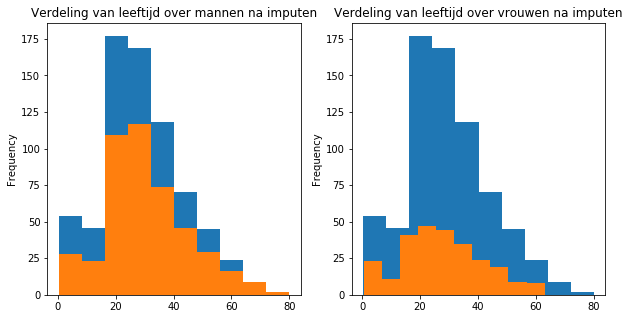

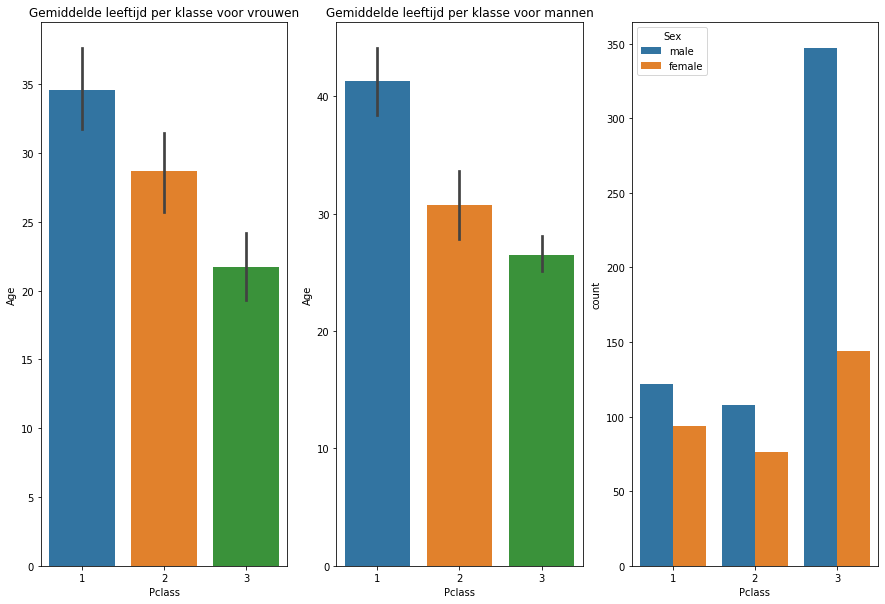

In [98]:
train.Age = train['Age']
# Mannen en vrouwen onderscheiden
male = train[train['Sex'] == 'male']
female = train[train['Sex'] == 'female']

# Mannen en vrouwen over het totaal plotten
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("Verdeling van leeftijd over mannen na imputen")
train.Age.plot('hist')
male.Age.plot('hist')
plt.subplot(1,2,2)
plt.title("Verdeling van leeftijd over vrouwen na imputen")
train.Age.plot('hist')
female.Age.plot('hist')

male.Age.mean(), female.Age.mean() # Gemiddelde leeftijd van mannen is hoger dan van vrouwen

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.title("Gemiddelde leeftijd per klasse voor vrouwen")
sns.barplot(female['Pclass'], female['Age'])
plt.subplot(1,3,2)
plt.title("Gemiddelde leeftijd per klasse voor mannen")
sns.barplot(male['Pclass'], male['Age'])   # Leeftijd en klasse correleren ook met elkaar
plt.subplot(1,3,3)
sns.countplot(train['Pclass'], hue=train['Sex']) # Ook meer mannen in derde klasse

In [99]:
### Vervangen van NA's afhankelijk van class en geslacht
for df in all_data:
    m_c1 = (df.Sex == 'male') & (df.Pclass == 1)
    m_c2 = (df.Sex == 'male') & (df.Pclass == 2)
    m_c3 = (df.Sex == 'male') & (df.Pclass == 3)
    f_c1 = (df.Sex == 'female') & (df.Pclass == 1)
    f_c2 = (df.Sex == 'female') & (df.Pclass == 2)
    f_c3 = (df.Sex == 'female') & (df.Pclass == 3)

    df.loc[m_c1, 'Age'] = df.loc[m_c1, 'Age'].fillna(df.loc[m_c1, 'Age'].mean())
    df.loc[m_c2, 'Age'] = df.loc[m_c2, 'Age'].fillna(df.loc[m_c2, 'Age'].mean())
    df.loc[m_c3, 'Age'] = df.loc[m_c3, 'Age'].fillna(df.loc[m_c3, 'Age'].mean())
    df.loc[f_c1, 'Age'] = df.loc[f_c1, 'Age'].fillna(df.loc[f_c1, 'Age'].mean())
    df.loc[f_c2, 'Age'] = df.loc[f_c2, 'Age'].fillna(df.loc[f_c2, 'Age'].mean())
    df.loc[f_c3, 'Age'] = df.loc[f_c3, 'Age'].fillna(df.loc[f_c3, 'Age'].mean())



In [100]:
### Checken of alles is gelukt voor verwijderen van na's in tit_copy:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [101]:
### Checken of alles is gelukt voor verwijderen van na's in test_copy:
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


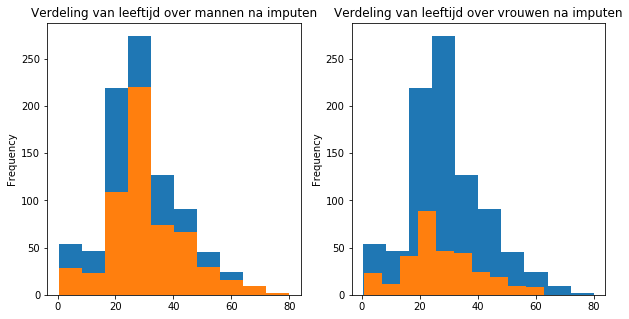

In [102]:
# Plotten na invullen van Na's
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("Verdeling van leeftijd over mannen na imputen")
train.Age.plot('hist')
train.loc[train.Sex == 'male', 'Age'].plot('hist')
plt.subplot(1,2,2)
plt.title("Verdeling van leeftijd over vrouwen na imputen")
train.Age.plot('hist')
train.loc[train.Sex == 'female', 'Age'].plot('hist')

#### Drop features die niet belangrijk zijn en verander de features daar waar nodig:
- Names: waarschijnlijk niet belangrijk
- Ticket: ook niet relevant
- Cabin: heel veel NA’s dus niet gebruiken
- PassengerID: niet relevant

In [103]:
## Remove names, ticket, cabin and passengerID
train = train.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1) 
test = test.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1) 

In [104]:
## Verander sex naar quantitatieve data    
train['Sex'] = train['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
test['Sex'] = test['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [118]:
## Verander embarked naar quantitatieve data:
train['Embarked'] = train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 3} ).astype(int)
test['Embarked'] = test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 3} ).astype(int)

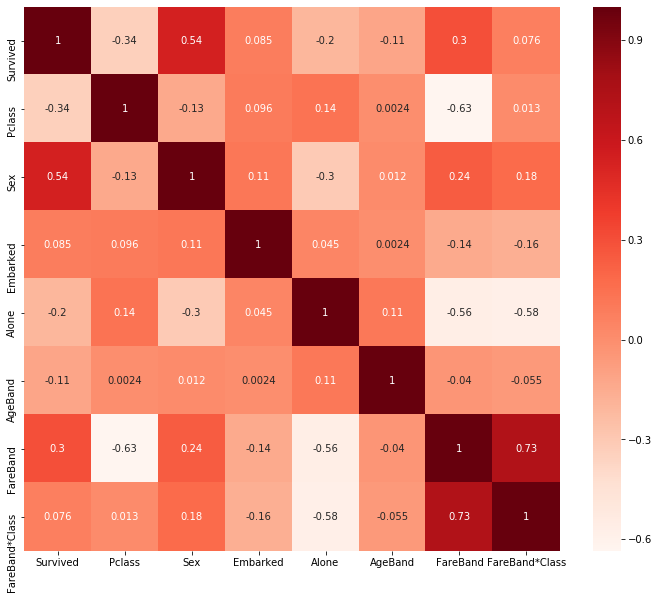

In [121]:
plt.figure(figsize=(12,10))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [122]:
#Correlation with output variable
cor_target = abs(cor["Survived"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Survived    1.000000
Sex         0.543351
Name: Survived, dtype: float64

In de plot hierboven is te zien dat geslacht als enige sterk samenhangt  met de overlevingskans.
Daarnaast correleren de features Parch en SibSp ook vrij sterk samen zoals te zien is in de plot hierboven. Daarom is het beter dat deze worden samengenomen. 

#### Transform and create attributes:
- Samenvoegen van SibSp en Parch >> wel of niet familielid aan boord 
    - Dit moet samen omdat ze ook sterk samen correleren (is ook logisch omdat ze hetzelfde verklaren)
- Kolom toevoegen met wel of niet volwassen
    - Gebaseerd op wat te zien is in plot ... (#Correlation between survival and age for man en die voor vrouwen)
    - Hier zag je dat bij een leeftijd van mannen onder de 18 en boven de 18 een groot verschil was.  
- Nieuwe feature maken van Pclass en Fare 

In [107]:
## Samenvoegen sib en  parch:
# 1 als men geen familie heeft
# 0 als men alleen is

# voor train
train['Family'] = train['SibSp'] + train['Parch'] + 1 
train['Alone'] = 0
train.loc[train['Family'] == 1, 'Alone'] = 1 

# voor test
test['Family'] = test['SibSp'] + test['Parch'] + 1 
test['Alone'] = 0
test.loc[test['Family'] == 1, 'Alone'] = 1 

# remove parch sibsp and family from the data
train = train.drop(['Parch', 'SibSp', 'Family'], axis=1)
test = test.drop(['Parch', 'SibSp', 'Family'], axis=1)

### Deze kunnen samengenomen worden omdat ze beide voor wel of geen familie in het algmeen staan.
### En als er dus geen familie mee is, is het 0 en als er kinderen danwel ouders van iemand zijn is het 1.

In [91]:
test["Age"].max()

76

In [109]:
## Wel of niet volwassen:
# Create age bands for younger than 18 (0) and older than 18 (1) and look at the possibility of surviving
train['Age'] = train['Age'].astype(int) # deze kan ook staan bij het invullen van de NaN's van age 
test['Age'] = test['Age'].astype(int) # deze kan ook staan bij het invullen van de NaN's van age 

# Bins maken van 0 tot 18 en 18 tot max leeftijd (80):
#df['AgeBand'] = pd.cut(df['Age'], bins=[0,18,80], labels=[0,1]) 
### MAAR BETER IS WAARSCHIJNLIJK AGE BANDS MAKEN VOOR 4 GROEPEN
train['AgeBand'] = pd.cut(train['Age'], bins=[0,18,30,50,80], labels=[0,1,2,3]) # qcut?
# anders voor test set:
test['AgeBand'] = pd.cut(test['Age'], bins=[0,18,30,50,76], labels=[0,1,2,3]) # qcut?


# Kans op overleven voor de groepen:
print(train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True))

# Deze hier pas anders wordt de kans op overleven verkeerd berekend:
train['AgeBand'] = train['AgeBand'].astype(int)
test['AgeBand'] = test['AgeBand'].astype(int)

# Remove AgeBand from the data
train = train.drop(['Age'], axis=1) 
test = test.drop(['Age'], axis=1) 

  AgeBand  Survived
0       0  0.477273
1       1  0.319809
2       2  0.431227
3       3  0.343750


In [111]:
# Create FareBands: 
# Here, we use qcut since we want the data to be separted equally
train['FareBand'] = pd.qcut(train['Fare'], 4, labels=[0,1,2,3])
test['FareBand'] = pd.qcut(test['Fare'], 4, labels=[0,1,2,3])

# Kans op overleven voor beide groepen:
print(train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True))

# Deze hier pas anders wordt de kans op overleven verkeerd berekend:
train['FareBand'] = train['FareBand'].astype(int)
test['FareBand'] = test['FareBand'].astype(int)

# Remove AgeBand from the data
train = train.drop(['Fare'], axis=1) 
test = test.drop(['Fare'], axis=1) 

  FareBand  Survived
0        0  0.197309
1        1  0.303571
2        2  0.454955
3        3  0.581081


In [112]:
## Create a new artificial feature for pclass en fare:
train['FareBand*Class'] = train.FareBand * train.Pclass
test['FareBand*Class'] = test.FareBand * test.Pclass


### Hier verwijderen we FareBand en class niet omdat deze niet precies hetzelfde betekenen.
### Wel kan er gekeken worden of de een effectiever is dan de ander maar dat komt later.


In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived          891 non-null int64
Pclass            891 non-null int64
Sex               891 non-null int64
Embarked          891 non-null int64
Alone             891 non-null int64
AgeBand           891 non-null int64
FareBand          891 non-null int64
FareBand*Class    891 non-null int64
dtypes: int64(8)
memory usage: 55.8 KB


In [126]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass            418 non-null int64
Sex               418 non-null int64
Embarked          418 non-null int64
Alone             418 non-null int64
AgeBand           418 non-null int64
FareBand          418 non-null int64
FareBand*Class    418 non-null int64
dtypes: int64(7)
memory usage: 22.9 KB


DINGEN DIE AANGEPASST KUNNEN WORDEN:
- features kunnen niet worden verwijderd of samengenomen
- andere age bands
- andere fare bands